# **Mini-batch K-Means** #

---



[Mini-batch K-means](https://ra.ethz.ch/cdstore/www2010/www/p1177.pdf)  is an unsupervised algorithm introduced by [D.Sculley](http://www.eecs.tufts.edu/~dsculley/)  in 2010.

The technique was initially proposed to address the extreme requirements for latency and scalability encountered in web applications. The main idea behind it, is to use mini-batch optimization for k-means clustering that shows surprising results by reducing computation cost by orders of magnitude compared to state of the art k-means.



[texte du lien](https://)In fact, mini-batch K-Means allows to process the whole dataset by using small random subsets of it, called $\textbf{mini-batches}$. Consequently, we do not need to store the whole dataset in memory, meaning that at each iteration, only the distances between a mini-batch and the $k$ centroids need to be computed, which allows to process very large dataset that cannot be stored into memory directly.




## The Steps

Consider having a dataset $X = \{x_{0},...,x_{n}\}$ where $x$ is a sample from $X$, and $n$ is the length of the dataset. And we want to cluster the dataset into $K$ clusters.
Some data:

The steps are:

1.   Initialize  a set of $C$ centroids randomly, with $C = \{c_{0},..,c_{K}\}$. 
2.   Shuffle then split the dataset into $M$ subsets of size $m$ (the size of the mini-batch).
3.   Compute the distance of each sample $d_{i}$ of every mini-batch to all clusters $K$, and select the nearest centroid $c$ to every $x_{i}$.
4.   Update the position of the selected centroid $c_{i}$ using gradient descent algorithm.



## The algorithm

$
```\\
v \ \textit{counts the number of sample that belongs to a cluster}\\ \eta \ \textit{is the learning rate}\\ t \ \textit{is the number of iterations}\\ k \ \textit{is the number of clusters}\\ M \ \textit{is the number of mini-batchs} \
\ f \ \textit{is the euclidean distance}.\\
```\\
\text{Initialize a set of centroids}\ \{c_{0},..c_{K}\}\in X\\ \\
v = [0,..,0]\in N^{k}, \   \\ 
\text{For} \ i = 1 \ \text{in} \ t  \ \text{do}:\\
\hspace{1cm}M \leftarrow m \ \text{examples}\\
\hspace{1cm}\text{for} \ x \ \text{in} \ M  \ \text{do}:\\
\hspace{2cm} l[x] \leftarrow min_{C}(f(C,x)) \\
\hspace{1cm}\text{end for} \\
\hspace{1cm}\text{for} \ x \ \text{in} \ M  \ \text{do}:\\
\hspace{2cm}c_{idx} \leftarrow  l[x] \\
\hspace{2cm}v[c_{idx}] \leftarrow v[c_{idx}] + 1 \\
\hspace{2cm}\eta \leftarrow \frac{1}{v[c_{idx}\ ]} \\
\hspace{2cm}c_{value} \leftarrow (1- \eta)\cdot c_{value} + \eta x\\
\hspace{1cm}\text{end for} \\
\text{end for} \\
$

As you may noticed, the learning $\eta$ is decreasing a learning rate $\eta$ that decreases with the number of iterations and the number of elements we have in a cluster. This learning rate is the inverse of number of examples assigned to a cluster during the process. As the number of iterations increases, the effect of new examples is reduced, so convergence can be
detected when no changes in the clusters occur in several consecutive iterations.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2 
import os
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import minmax_scale
import seaborn as sns

## Loading Data

In [ ]:
def load_data(path_dir):
  data = []
  target_name = os.listdir(path_dir) # A list that contains the name of each subfolder ( class )
  labels = np.arange(0,len(os.listdir(path_dir)),1) # Associate each subfolders to a class.

  for t,l in zip(target_name ,labels):
    new_path = os.path.join(path_dir,t)
    images_list = os.listdir(new_path)
    for image in images_list:
      image_path = os.path.join(path_dir,t,image)
      im = cv2.imread(image_path,cv2.IMREAD_COLOR)
      im = cv2.resize(im, (0, 0), fx = 0.5, fy = 0.5)

      data.append([im,l])
  return data

In [ ]:
!unzip /content/drive/MyDrive/Big_Leuk_dataset.zip
#!unzip /content/drive/MyDrive/Leuk_dataset.zip

In [ ]:
# Choose the right path
#!unzip Leuk_dataset
path1 = '/content/Leuk_dataset'
path2 = '/content/Big_Leuk_dataset'

data = load_data(path2)


## Data visualization

In [ ]:
def visualize_data(path):
  labels = os.listdir(path) # A list that contains the name of each subfolder ( class )
  labels_map = {
      0: "EOS",
      1: "LYT",
      2: "MON",
      3: "NGS",
  }
  figure = plt.figure(figsize=(20, 10))
  cols, rows = 4, 1
  for i,label,label_index in zip(range(1, cols * rows + 1),labels,range(0,4)):
      len_class = len(os.listdir(os.path.join(path,label)))
      sample_idx = np.random.randint(len_class, size=(1,)).item()
      img_path = os.listdir(os.path.join(path,label))
      img = cv2.imread(os.path.join(path,label,img_path[sample_idx]))
      figure.add_subplot(rows, cols, i)
      plt.title(labels_map[label_index])
      plt.axis("off")
      plt.imshow(img.squeeze())
  plt.show()



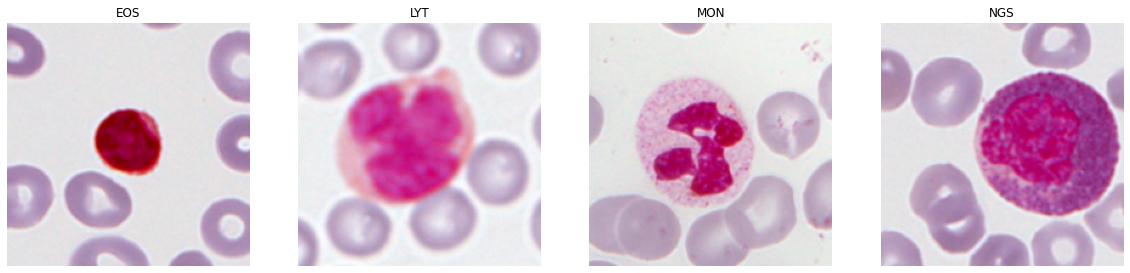

In [ ]:
visualize_data(path2)



1.   The eosinophilic (EOS) leukocyte has been implicated as a primary effector cell in inflammatory and allergic diseases. \\
2.   T Lymphocyte ( LYT)  are responsible of cellular immunity: cells infected with a virus for example, or cancer cells recognized as foreign to the body (i.e. distinct from cells that T lymphocytes have learned to tolerate during maturation) are destroyed by a complex mechanism.\\
3.   Monocytes ( MON ) they ingest and destroy pathogens and small cell residues
4.   Granulocytes ( NGS ) are versatile white blood cells. For example, they can ingest pathogens as does the MON monocyte, it is also a messenger between white blood cells


# The implementation

In [ ]:
## Extract images, and labels from the dataset
X = []
Y = []
for i in range(len(data)):
  X.append(np.ravel(data[i][0]))
  Y.append(data[i][1])

In [ ]:
from sklearn.preprocessing import minmax_scale

## Normalize the input, mean = 0, std = 1
X_scale = minmax_scale(X)

## **Regular KMeans**

In [ ]:
from sklearn.cluster import KMeans

def regular_kmeans(data,n,n_iterations=300):
  start_regular = time.time()

  regular_kmeans = KMeans(n_clusters=n,   # 4 clusters because we have 4 classes
                              random_state = 7,
                              max_iter = n_iterations
                              ).fit(data)

  predicted_labels = regular_kmeans.predict(data)

  end_regular = time.time()
  time_of_execution = end_regular - start_regular
  #print(time_of_execution, "seconds for the regular KMeans")
  return predicted_labels, time_of_execution


## **Mini-batch KMeans**

In [ ]:
from sklearn.cluster import MiniBatchKMeans

def minibatch_kmeans(data,n,b,n_iterations=300):
  start_mb = time.time()

  mb_kmeans = MiniBatchKMeans(n_clusters=n,   # 4 clusters because we have 4 classes
                              batch_size=b,
                              random_state = 7,
                              max_iter = n_iterations
                              ).fit(data)

  mbkmeans_labels = mb_kmeans.predict(data)
  end_mb = time.time()
  time_of_execution = end_mb - start_mb
  #print(time_of_execution, "seconds for the mini-batch KMeans")
  return mbkmeans_labels, time_of_execution,mb_kmeans

# Batch size impact on the algorithm

In [ ]:
list_time_execution = []


b_list =[8,64,256,512,1024]
for batch_size in b_list :
  n = 4 # Number of clusters
  mbkmeans_labels,execution_time = minibatch_kmeans(X_scale,n,batch_size)
  list_time_execution.append(execution_time)

list_time_execution = []


for batch_size in b_list :
  n = 4 # Number of clusters
  mbkmeans_labels,execution_time = regular_kmeans(X_lda,n)
  list_time_execution.append(execution_time)


2.747250556945801 seconds for the mini-batch KMeans
2.417343854904175 seconds for the mini-batch KMeans
6.046719551086426 seconds for the mini-batch KMeans
8.889386653900146 seconds for the mini-batch KMeans
20.138374090194702 seconds for the mini-batch KMeans


The algorithm has almost 96% accuracy, which is huge, thanks to the LDA ( Linear Discriminative Analysis ), that helps us reduce the dimension, and resume all the dataset in 3 axes.

In the figure below it is shown the time for convergence using different minibatch sizes.
We can clearly notice, that time execution depends on the size of the minibatch choosen. The bigger the size of the batch, the slower will be the algorithm execution.
An expected result is that the time needed for convergence using only a sample of the dataset is less than the time needed using all the data. We can also say that execution time increases linearly with the batch size that will be considered as the explanatory variable, we conclude that there is a linear relationship between these two variables.

Text(0, 0.5, 'Execution time ( in seconds )')

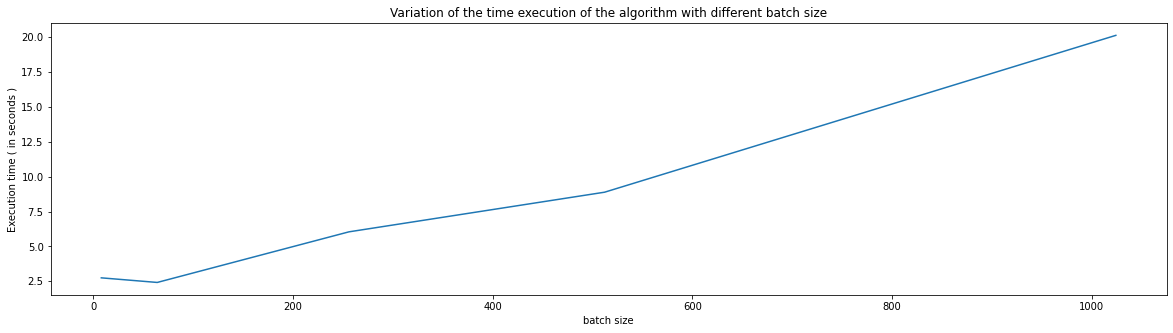

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(b_list,list_time_execution)
ax.set_title("Variation of the time execution of the algorithm with different batch size")
ax.set_xlabel("batch size")
ax.set_ylabel("Execution time ( in seconds )")


## Impact of number of cluster on the execution time 

In [ ]:
list_time_execution = []
batch = [256,512,1024,2056,3896]
cluster =[4,16,64,128]
for n in cluster:
  for b in batch:
    mbkmeans_labels,execution_time = minibatch_kmeans(X_scale,n,b)
    list_time_execution.append(execution_time)


In [ ]:
batch_pct = [256/X_scale.shape[0],512/X_scale.shape[0],1024/X_scale.shape[0],3000/X_scale.shape[0],3896/X_scale.shape[0]]

In [ ]:
r_list_time_execution = []
cluster =[4,16,64,128]
for n in cluster:
   # Number of clusters
  regular_kmeans_labels,r_execution_time = regular_kmeans(X_scale,n)
  r_list_time_execution.append(r_execution_time)

147.6503369808197 seconds for the regular KMeans
299.91227626800537 seconds for the regular KMeans
672.2945756912231 seconds for the regular KMeans
1064.363074541092 seconds for the regular KMeans


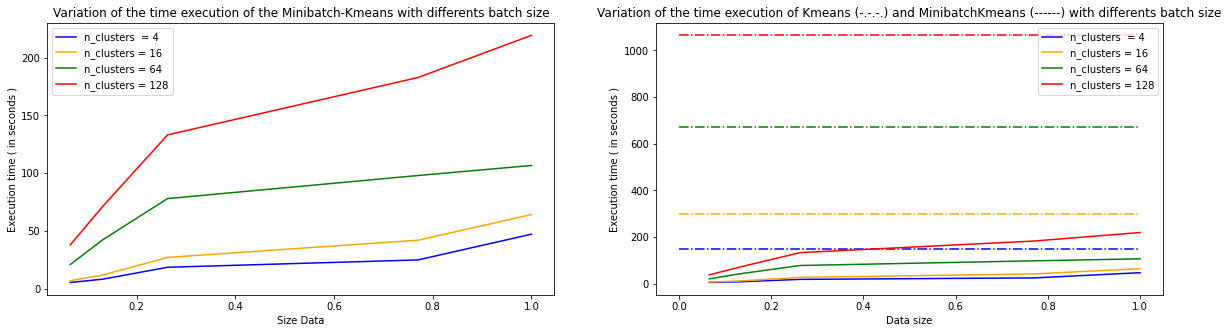

In [ ]:

fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(batch_pct,list_time_execution[:5],'b')
ax[0].plot(batch_pct,list_time_execution[5:10],'orange')
ax[0].plot(batch_pct,list_time_execution[10:15],'g')
ax[0].plot(batch_pct,list_time_execution[15:20],'r')
ax[0].set_title("Variation of the time execution of the Minibatch-Kmeans with differents batch size")
ax[0].set_xlabel("Size Data")
ax[0].set_ylabel("Execution time ( in seconds )")
ax[0].legend(['n_clusters  = 4','n_clusters = 16','n_clusters = 64','n_clusters = 128'])


ax[1].plot(batch_pct,list_time_execution[:5],'b')
ax[1].plot(batch_pct,list_time_execution[5:10],'orange')
ax[1].plot(batch_pct,list_time_execution[10:15],'g')
ax[1].plot(batch_pct,list_time_execution[15:20],'r')
ax[1].hlines(r_list_time_execution[0],0,1,'b',linestyles='-.',)
ax[1].hlines(r_list_time_execution[1],0,1,'orange',linestyles='-.',)
ax[1].hlines(r_list_time_execution[2],0,1,'g',linestyles='-.',)
ax[1].hlines(r_list_time_execution[3],0,1,'r',linestyles='-.',)

ax[1].set_title("Variation of the time execution of Kmeans (-.-.-.) and MinibatchKmeans (------) with differents batch size")
ax[1].set_xlabel("Data size")
ax[1].set_ylabel("Execution time ( in seconds )")
ax[1].legend(['n_clusters  = 4','n_clusters = 16','n_clusters = 64','n_clusters = 128'])




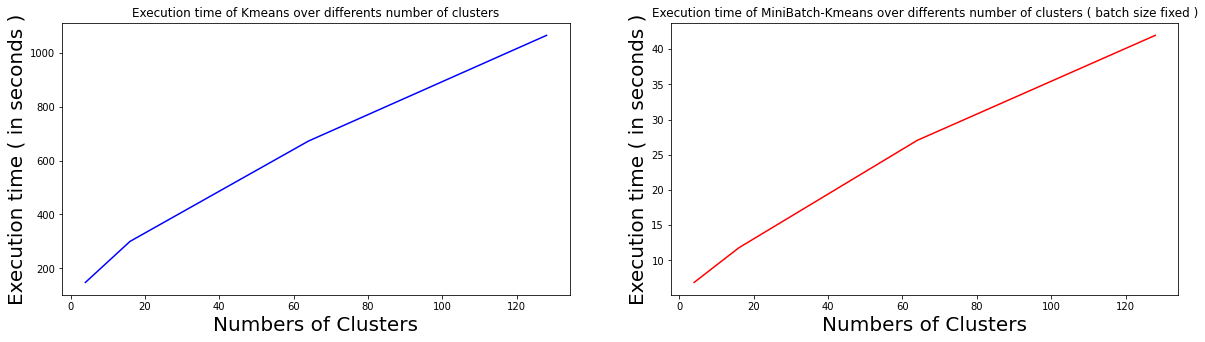

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_title("Execution time of Kmeans over differents number of clusters",size = 12)
ax[0].set_xlabel("Numbers of Clusters",size = 20)
ax[0].set_ylabel("Execution time ( in seconds )",size = 20)
ax[0].plot(cluster,r_list_time_execution,'b')
ax[1].set_title("Execution time of MiniBatch-Kmeans over differents number of clusters ( batch size fixed )",size = 12)
ax[1].set_xlabel("Numbers of Clusters",size = 20)
ax[1].set_ylabel("Execution time ( in seconds )",size = 20)
ax[1].plot(cluster,list_time_execution[5:9],'r')

As the number of clusters and the number of examples increase in the mini-batch, the relative saving in computational time also increases. The saving in computational time  is more noticeable only when the number of clusters is very large. The effect of the the data size in the computational time is also more evident when the number of clusters is larger. From the graphic it can be seen that the computational time increases linearly as the size of the dataset increases linearly (doubling the number of examples doubles the time needed for the minibatch-kmeans).Next, we can also observe that the computational time of the mini batch k-means algorithm is drastically reduced when the number of clusters is large, whereas the computational time of the k-means increased exponentially for different number of clusters

## CPu utilization

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

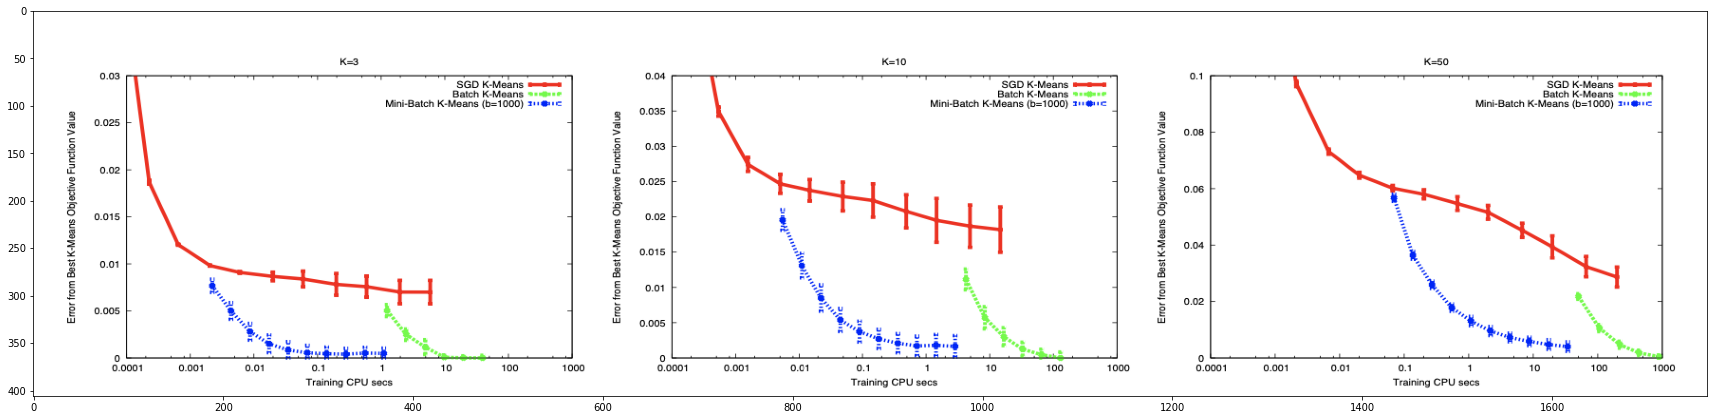

In [ ]:
plt.figure(figsize=(30,10))
plt.imshow(mpimg.imread('/content/img.png'))

## Cluster Separation quality

**Calinski Score**: is defined as ratio between the within-cluster dispersion and the between-cluster dispersion.

**Silhouette Score**: this score will, on the other hand, validates performance based on intra and inter-cluster distances.


In our case, we know that there is 4 classes. So we're going to measure the clustering quality regarding 4 clusters.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import calinski_harabasz_score,silhouette_score

n = 4 
mbkmeans_labels,execution_time = minibatch_kmeans(X_scale,n,128)
rmeans_labels,execution_time = regular_kmeans(X_scale,n)

In [ ]:
print("silhouette score of MiniBatch Kmeans is {}".format(silhouette_score(X_scale,mbkmeans_labels)))
print("silhouette score of Regular Kmeans is {}",silhouette_score(X_scale,regular_kmeans_labels))

silhouette score of MiniBatch Kmeans is 0.0388997018872323
silhouette score of Regular Kmeans is {} 0.002926148700030303


**We obtain bad cohesion and separation using both, kmeans and mini-batch Kmeans, however the silhouette score of the MiniBtachKmeans is 10 time better than the silhouette score of the Kmeans algorithm**

In this notebook, we propose an approach based on Linear Discriminative Analysis ( LDA ) to reduce the dimensionality of the problem. In fact, we already have the labels of the class, so instead of using a simple PCA that will project the data into a new space, the LDA will do the same but it will take into account the class of each sample.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

Variance explained by the first principal components is 15.361644047648163%
Variance explained by the first principal components is 79.32709903318043%


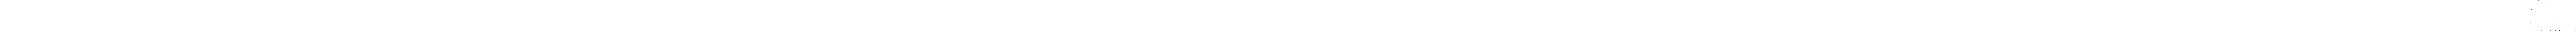

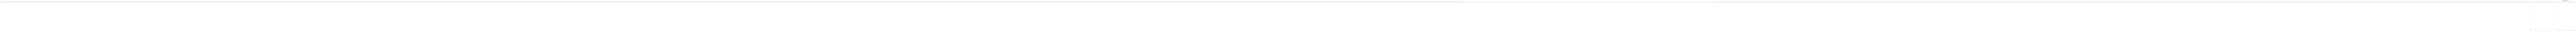

In [ ]:
  pca_2D = PCA(n_components=2)

  x_pca_2D = pca_2D.fit_transform(X_scale)

  lda_2D = LDA(solver='svd',n_components=2)

  x_lda_2D = lda_2D.fit_transform(X_scale,Y)

  print("Variance explained by the first principal components of PCA is {}%".format(100*pca_2D.explained_variance_ratio_.sum()))


  print("Variance explained by the first principal components of LDA is {}%".format(100*lda_2D.explained_variance_ratio_.sum()))



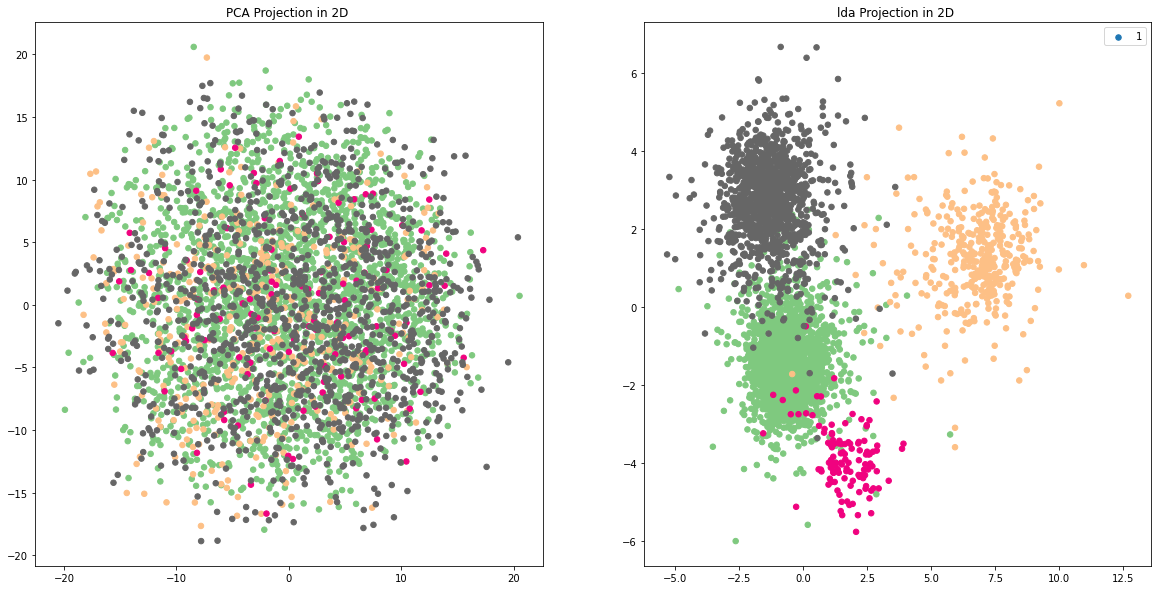

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].set_title('PCA Projection in 2D ')
ax[0].scatter(x_pca_2D[:,0],x_pca_2D[:,1],c=Y,s=30,cmap='Accent')
ax[1].legend(['1','2','3','4'])
ax[1].set_title('lda Projection in 2D ')
ax[1].scatter(x_lda_2D[:,0],x_lda_2D[:,1],c=Y,s=30,cmap='Accent')
ax[1].legend(['1','2','3','4'])
fig.show()

We notice that the projection of the LDA is much better than the one performed by PCA, while expressing a lot more of inertia ($\approx$ 80% vs 15% for PCA). But we can do even better, by adding another plane to the projection.

LDA made some assumptions about the data:


*   LDA approaches the problem by assuming that the conditional probability density functions follow normal distributions
*   LDA  makes the  homoscedasticity assumption :  that the class covariances are identical.

It has been suggested that discriminant analysis is relatively robust to slight violations of these assumptions.



## LDA 3D

In [ ]:
import plotly.express as px
import pandas as pd
def lda_projection(data,labels):
  lda_3D = LDA(solver='svd',n_components=3)

  x_lda_3D = lda_3D.fit_transform(data,labels)

  print("the variance expressed by the projection in 3D is {}%".format(100*lda_3D.explained_variance_ratio_.sum()))
  df = pd.DataFrame()
  df['lda1'] = x_lda_3D[:,0]
  df['lda2'] = x_lda_3D[:,1]
  df['lda3'] = x_lda_3D[:,2]
  df['label'] = labels
  plt.figure('LDA Projection of the dataset in 3D using minibatch-kmeans labels ')
  fig = px.scatter_3d(df, x='lda1', y='lda2', z='lda3',
                color='label')
  fig.show()
  return df,lda_3D

In [ ]:
df,lda_3D = lda_projection(X_scale,Y)

the variance expressed by the projection in 3D is 99.99999999999999%


<Figure size 432x288 with 0 Axes>

Awesome ! we can notice that **99% of the inertia is conserved** ! let's projec our image dataset into this space, and perform the clustering using mini-batch Kmeans.

In [ ]:
#X_lda = df[['lda1','lda2','lda3']].values
X_lda = lda_3D.transform(X_scale)
mbkmeans_labels, time_of_execution,mbkmean_model =  minibatch_kmeans(X_lda,4,1024,n_iterations=1000);
print("silhouette score of MiniBatch Kmeans on LDA components is {}".format(silhouette_score(X_lda,mbkmeans_labels)))

silhouette score of MiniBatch Kmeans on LDA components is 0.5837708099195238


In [ ]:
rmeans_labels, time_of_execution =  regular_kmeans(X_lda,4,n_iterations=300);
print("silhouette score of MiniBatch Kmeans on LDA components is {}".format(silhouette_score(X_lda,rmeans_labels)))

0.06907939910888672 seconds for the regular KMeans
silhouette score of MiniBatch Kmeans on LDA components is 0.5839044307061694


The silhouette score on the transformed data increased up to 20 times. We can justify that by the fact that LDA projection helps the algorithm to better categorize each class, because LDA projects each data point according to its respective class, which make it easier to differentiate between class $Y_{i}$ and $Y_{j}$

## Confusion Matrix

Text(0.5, 24.0, 'Y_pred')

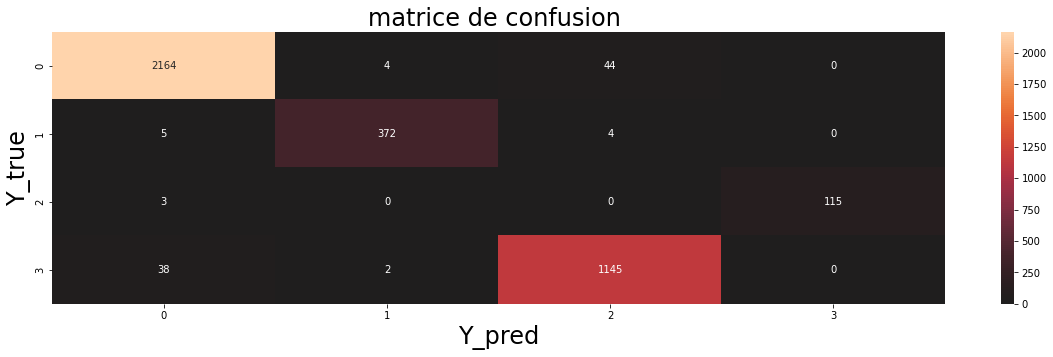

In [ ]:
mat = confusion_matrix(Y,mbkmeans_labels)
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.set_title("matrice de confusion ", size = 24)
ax = sns.heatmap(mat, center=0,annot=True, fmt="d",)
ax.set_ylabel("Y_true", size = 24)
ax.set_xlabel("Y_pred", size = 24)

It seems that some cluster ID is related to classes, much more than others. We should then do a mapping.

In [ ]:
from sklearn.metrics import accuracy_score

new_list = []

for i in range(len(mbkmeans_labels)):
  if mbkmeans_labels[i] == 0 :
    new_list.append(0)
  elif mbkmeans_labels[i] == 1:
    new_list.append(1)
  elif mbkmeans_labels[i] == 2:
    new_list.append(3)
  elif mbkmeans_labels[i] == 3:
    new_list.append(2)



accuracy_score(new_list,Y)

0.9743326488706365

We got 97% accuracy, means that we correctly categorize our data points according to its class. Because Kmeans and MiniBatchKmeans have almost the same silhouette score, we suppose that they will perform the same in term of accuracy.

## Validation

In order to validate the model, we need to test it in a validation dataset in order to confirm that the mapping between the cluster ID and the true class is correct.

**For that, we're going to test the minibatchKmeans on a dataset of 1044 images**.

In [ ]:
path1 = '/content/Leuk_dataset'
import random
data_test = load_data(path1)

In [ ]:
## Extract images, and labels from the dataset
random.shuffle(data_test)
X_test = []
Y_test = []
for i in range(len(data_test)):
  X_test.append(np.ravel(data_test[i][0]))
  Y_test.append(data_test[i][1])

In [ ]:
from sklearn.preprocessing import minmax_scale

## Normalize the input, mean = 0, std = 1
X_scale_test = minmax_scale(X_test)

In [ ]:
X_scaled_test_lda = lda_3D.transform(X_scale_test)

Text(0.5, 24.0, 'Y_pred')

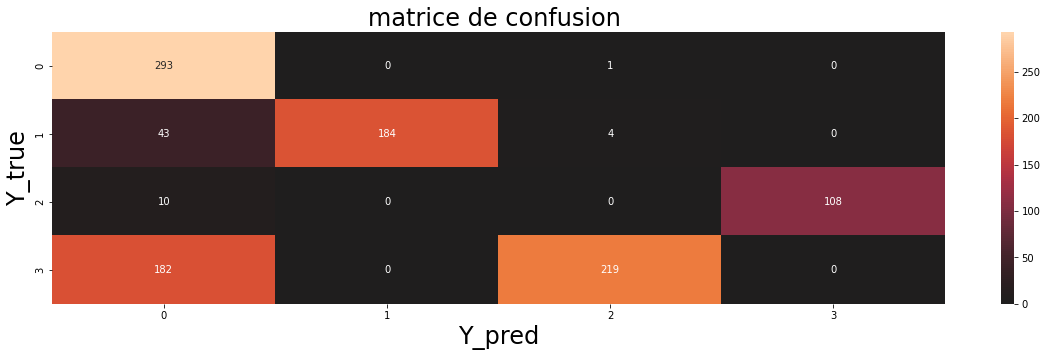

In [ ]:
y_pred_test = mbkmean_model.predict(X_scaled_test_lda)
mat = confusion_matrix(Y_test,y_pred_test)
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.set_title("matrice de confusion ", size = 24)
ax = sns.heatmap(mat, center=0,annot=True, fmt="d",)
ax.set_ylabel("Y_true", size = 24)
ax.set_xlabel("Y_pred", size = 24)

In [ ]:
from sklearn.metrics import accuracy_score

new_list_test = []

for i in range(len(y_pred_test)):
  if y_pred_test[i] == 0 :
    new_list_test.append(0)
  elif y_pred_test[i] == 1:
    new_list_test.append(1)
  elif y_pred_test[i] == 2:
    new_list_test.append(3)
  elif y_pred_test[i] == 3:
    new_list_test.append(2)

accuracy_score(new_list_test,Y_test)

0.7701149425287356

The clustering performs good at the validation dataset. We notice that the algorithm has difficulties to differentiate between class 0 and 3, we can justify that by the fact that the dataset is imbalanced

## Effect of small dimensions on minibatch-kmeans and kmeans

In [ ]:
list_time_execution = []


b_list =[64,256,512,1024]
for batch_size in b_list :
  n = 4 # Number of clusters
  mbkmeans_labels,execution_time = minibatch_kmeans(X_lda,n,batch_size)
  list_time_execution.append(execution_time)

list_time_execution = []


for batch_size in b_list :
  n = 4 # Number of clusters
  mbkmeans_labels,execution_time = regular_kmeans(X_lda,n)
  list_time_execution.append(execution_time)


0.05860257148742676 seconds for the mini-batch KMeans
0.030687332153320312 seconds for the mini-batch KMeans
0.02958083152770996 seconds for the mini-batch KMeans
0.03917336463928223 seconds for the mini-batch KMeans
0.06109809875488281 seconds for the regular KMeans
0.06621813774108887 seconds for the regular KMeans
0.06016969680786133 seconds for the regular KMeans
0.05970120429992676 seconds for the regular KMeans


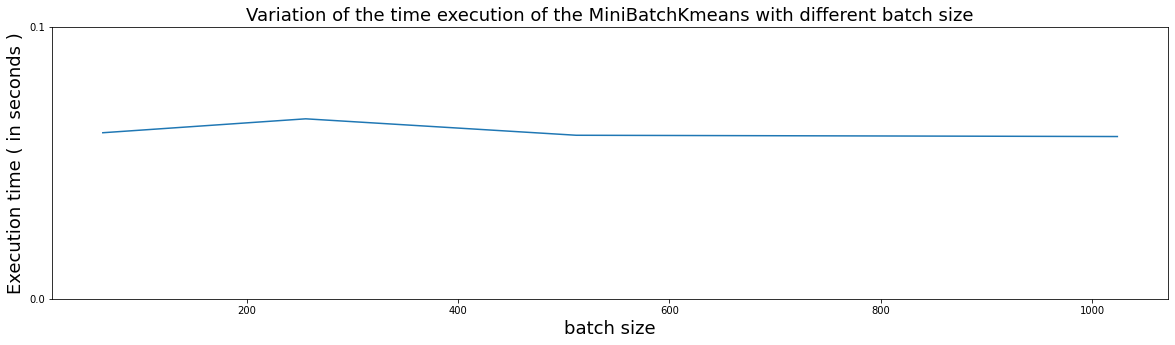

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(b_list,list_time_execution)
ax.set_title("Variation of the time execution of the MiniBatchKmeans with different batch size",size = 18)
ax.set_xlabel("batch size",size = 18)
ax.set_ylabel("Execution time ( in seconds )",size = 18)
ax.set_yticks([0,0.1])

We notice that when dealing with small dimensions dataset, the batch size of the minibatch-kmeans doesn't really affect the execution time of the algorithm as the figure above shows.

In [ ]:
r_list_time_execution = []
cluster =[4,16,64,128]
for n in cluster:
   # Number of clusters
  regular_kmeans_labels,r_execution_time = regular_kmeans(X_lda,n)
  r_list_time_execution.append(r_execution_time)

0.0751502513885498 seconds for the regular KMeans
0.5385439395904541 seconds for the regular KMeans
1.5772383213043213 seconds for the regular KMeans
2.3731019496917725 seconds for the regular KMeans


In [ ]:
list_time_execution = []
cluster =[4,16,64,128]
for n in cluster:
   # Number of clusters
  bm_kmeans_labels,execution_time = minibatch_kmeans(X_lda,n,128)
  list_time_execution.append(execution_time)

0.037186384201049805 seconds for the mini-batch KMeans
0.1303715705871582 seconds for the mini-batch KMeans
0.2018442153930664 seconds for the mini-batch KMeans
0.21007108688354492 seconds for the mini-batch KMeans


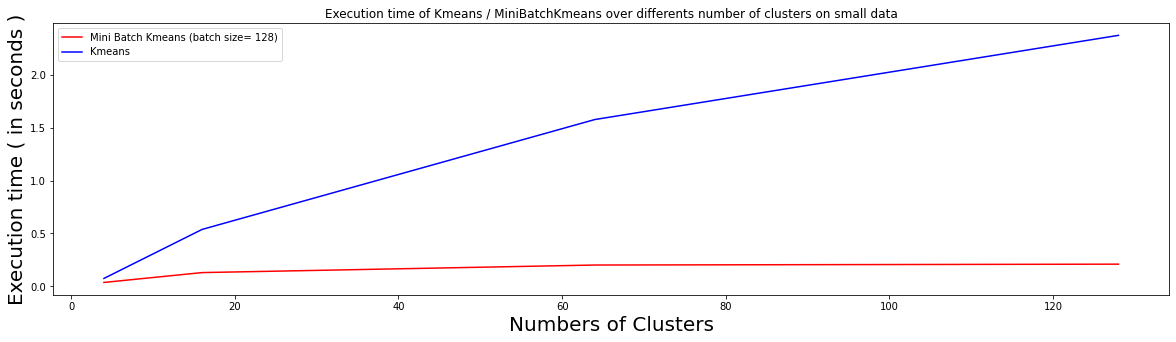

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
ax.set_title("Execution time of Kmeans / MiniBatchKmeans over differents number of clusters on small data",size = 12)
ax.set_xlabel("Numbers of Clusters",size = 20)
ax.set_ylabel("Execution time ( in seconds )",size = 20)
ax.plot(cluster,list_time_execution,'r')
ax.plot(cluster,r_list_time_execution,'b')
ax.legend(["Mini Batch Kmeans (batch size= 128)", "Kmeans"])

We still notice that minibatch-kmeans performs better than Regular Kmean even on small dataset ! but the expanse  is not as marked as it is on big dataset.